In [1]:
%reset -f
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
 
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
# from pyimagesearch.lenet import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import numpy as np


# initialize the number of epochs to train for, initial learning rate,
# and batch size
epochs = 100
batch_size = 32
monitor='val_loss'
es_patience=7
rlr_patience=3
img_width, img_height = 65,65
modelname = 'testnopretune'

In [2]:
def get_dataset(dataset='./insectrec/created_data/impy_crops_export/'):
    # initialize the data and labels
    print(" loading images...")
    data = []
    labels = []

    # grab the image paths and randomly shuffle them
    imagePaths = sorted(list(paths.list_images(dataset)))
    random.seed(42)
    random.shuffle(imagePaths)

    # loop over the input images
    for imagePath in imagePaths:
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_width, img_height))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)

    # scale the raw pixel intensities to the range [0, 1]
    data = np.array(data, dtype="float") / 255.0

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data,
        labels, test_size=0.2, random_state=42)
    return trainX, testX, trainY, testY, labels

_, testX, _, testY, _ = get_dataset(dataset='./insectrec/created_data/impy_crops_export/')
trainX, _, trainY, _, labels = get_dataset(dataset='./insectrec/created_data/images_augmented/')

# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=6)
testY = to_categorical(testY, num_classes=6)

 loading images...
 loading images...


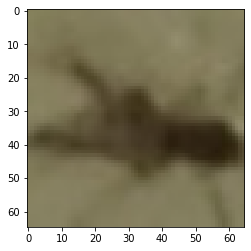

(3516, 65, 65, 3)

In [3]:
plt.imshow(testX[208])
plt.show()
testX.shape

In [4]:
# construct the image generator for data augmentation
aug = ImageDataGenerator()
#     rotation_range=30, width_shift_range=0.1,
#     height_shift_range=0.1, zoom_range=0.3,
#     horizontal_flip=True, vertical_flip=True,fill_mode="nearest")

In [5]:
log_dir = './insectrec/created_data/logs/'
top_weights_path = f'./insectrec/created_data/weights/model_{modelname}_{img_width}.h5'

callbacks_list = [ModelCheckpoint(monitor =  monitor,
                                  filepath =  top_weights_path,
                                  save_best_only = False,
                                  save_weights_only = False,
                                  verbose = 1),
                  EarlyStopping(monitor =  monitor,
                                patience =  es_patience,
                                verbose = 1),
                  ReduceLROnPlateau(monitor =  monitor,
                                    factor = 0.1,
                                    patience =  rlr_patience,
                                    verbose = 1),
                # CSVLogger(filename =  logfile),
                  TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)]

## TRAINING FROM SCRATCH

In [6]:
#base_model = DenseNet121(include_top=True, weights=None, 
#                         input_shape=(img_width,img_height,3))
#x = base_model.output
#predictions = Dense(6, activation='softmax')(x)

#model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#FH = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
#    validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
#    epochs=epochs, verbose=1, callbacks=callbacks_list)

## FINE TUNING

In [9]:
base_model = DenseNet121(include_top=False, weights='imagenet', 
                         input_shape=(img_width,img_height,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

In [11]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
FH = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs, verbose=1, callbacks=callbacks_list)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/100
1429/1430 [============================>.] - ETA: 1s - loss: 1.2415 - accuracy: 0.5576
Epoch 00001: saving model to ./insectrec/created_data/weights/model_testnopretune_65.h5
1430/1430 [==============================] - 1761s 1s/step - loss: 1.2414 - accuracy: 0.5576 - val_loss: 1.4414 - val_accuracy: 0.5398
Epoch 2/100
1429/1430 [============================>.] - ETA: 1s - loss: 1.1839 - accuracy: 0.5739
Epoch 00002: saving model to ./insectrec/created_data/weights/model_testnopretune_65.h5
1430/1430 [==============================] - 1765s 1s/step - loss: 1.1842 - accuracy: 0.5738 - val_loss: 1.5003 - val_accuracy: 0.4858
Epoch 3/100
1429/1430 [============================>.] - ETA: 1s - loss: 1.1984 - accuracy: 0.5929
Epoch 00003: saving model to ./insectrec/created_data/weights/model_testnopretune_65.h5
1430/1430 [==============================] - 1766s 1s/step - loss: 1.1987 - accuracy: 0.5928 - val_loss: 3.9295 - val_accuracy: 0.3817
Epoch 4/100
1429/1430 [===========

In [12]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:425]:
   layer.trainable = False
for layer in model.layers[425:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
FH2 = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs, verbose=1, callbacks=callbacks_list)

Epoch 1/100
1429/1430 [============================>.] - ETA: 1s - loss: 1.0447 - accuracy: 0.6123
Epoch 00001: saving model to ./insectrec/created_data/weights/model_test_65.h5
1430/1430 [==============================] - 1554s 1s/step - loss: 1.0445 - accuracy: 0.6125 - val_loss: 1.6603 - val_accuracy: 0.4329
Epoch 2/100
1429/1430 [============================>.] - ETA: 1s - loss: 1.0006 - accuracy: 0.6309
Epoch 00002: saving model to ./insectrec/created_data/weights/model_test_65.h5
1430/1430 [==============================] - 1553s 1s/step - loss: 1.0006 - accuracy: 0.6309 - val_loss: 1.5855 - val_accuracy: 0.4386
Epoch 3/100
1429/1430 [============================>.] - ETA: 1s - loss: 0.9852 - accuracy: 0.6356
Epoch 00003: saving model to ./insectrec/created_data/weights/model_test_65.h5
1430/1430 [==============================] - 1557s 1s/step - loss: 0.9853 - accuracy: 0.6356 - val_loss: 2.0392 - val_accuracy: 0.3916
Epoch 4/100
1429/1430 [============================>.] - ETA: